In [1]:
import numpy as np
import pandas as pd
import cv2
import random
import csv
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
%matplotlib inline

In [2]:
from model import get_model
from generator import generator, get_image

Using TensorFlow backend.


In [3]:
base_path = '../../datasets/german_traffic_signs/'
train_path = base_path + 'imgs/train'
test_path = base_path + 'imgs/test'

In [4]:
imgpaths = [os.path.join(root, f).replace('\\', '/')
            for root, _, files in os.walk(train_path) 
            for f in files if f.endswith('.ppm')]
random.shuffle(imgpaths)

In [5]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(imgpaths, test_size=0.1, random_state=42)

n_train, n_valid = len(train), len(valid)
n_classes = len(list(open(base_path + 'signnames.csv'))) - 1

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of classes =", n_classes)

Number of training examples = 35288
Number of validation examples = 3921
Number of classes = 43


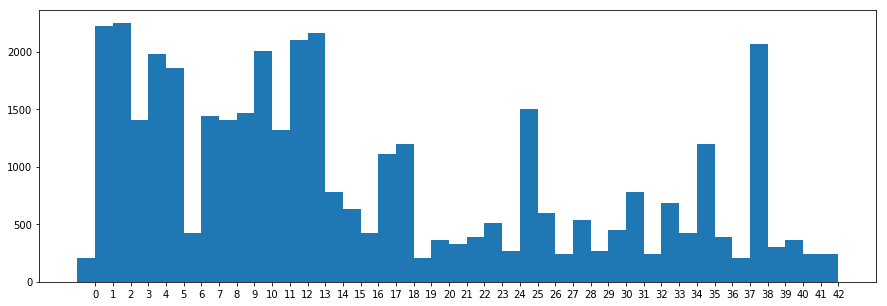

In [6]:
cls_counter = Counter()
y_train = []
for path in imgpaths:
    cls = int(path.split('/')[-2])
    y_train.append(cls)
    cls_counter[cls] += 1
    
labels, values = cls_counter.keys(), cls_counter.values()
indexes = np.arange(len(labels))

plt.figure(figsize=(15,5))
plt.bar(indexes, values, width=1)
plt.xticks(indexes + 0.5, labels)
plt.show()

In [7]:
class_weights = compute_class_weight('balanced', indexes, y_train)
cw_dict = dict(zip(indexes, class_weights))
cw_dict

{0: 4.3420819490586933,
 1: 0.41073748166771423,
 2: 0.40526098191214471,
 3: 0.64669305624278406,
 4: 0.46052384308198263,
 5: 0.49023505876469115,
 6: 2.1710409745293466,
 7: 0.63322028423772614,
 8: 0.64669305624278406,
 9: 0.62029742129409904,
 10: 0.45365035288672917,
 11: 0.69078576462297392,
 12: 0.43420819490586932,
 13: 0.42214685615848407,
 14: 1.1690220632081096,
 15: 1.447360649686231,
 16: 2.1710409745293466,
 17: 0.82147496333542847,
 18: 0.75986434108527134,
 19: 4.3420819490586933,
 20: 2.5328811369509046,
 21: 2.7631430584918957,
 22: 2.3380441264162193,
 23: 1.7879160966712266,
 24: 3.3771748492678726,
 25: 0.6078914728682171,
 26: 1.5197286821705427,
 27: 3.7993217054263564,
 28: 1.6885874246339363,
 29: 3.3771748492678726,
 30: 2.0263049095607237,
 31: 1.1690220632081096,
 32: 3.7993217054263564,
 33: 1.3234212036318223,
 34: 2.1710409745293466,
 35: 0.75986434108527134,
 36: 2.3380441264162193,
 37: 4.3420819490586933,
 38: 0.44050106729580946,
 39: 3.0394573643410

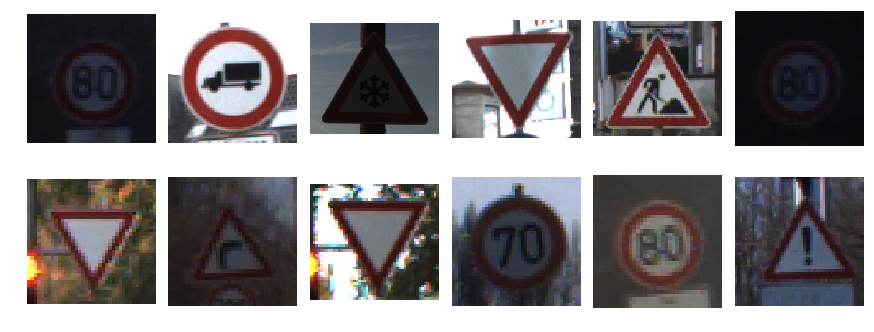

In [8]:
gs = gridspec.GridSpec(2, 6)
gs.update(wspace=0.1, hspace=0)
plt.figure(figsize=(15, 6))

sample = np.random.choice(imgpaths, size=12)
for i, path in enumerate(sample):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    ax = plt.subplot(gs[i])
    ax.set_aspect('equal')    
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

In [9]:
train_gen = generator(train, n_classes=n_classes, batch_size=16, augment=False)
valid_gen = generator(valid, n_classes=n_classes, batch_size=16)

In [10]:
model = get_model((32, 32, 3), n_classes=n_classes)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   1216        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

## Train and validate model

After 45 epochs:
- train set: loss: 0.0204 - acc: 0.9922 
- validation set: val_loss: 0.0208 - val_acc: 0.9959

In [11]:
from keras.callbacks import ModelCheckpoint

weights_path = 'weights/tsrnet.hdf5'

try:
    model.load_weights(weights_path)
    print('Weights are loaded.')
except OSError:
    print('Weights of pretrained model were not found. Model should be trained first.')
    model.fit_generator(generator=train_gen,
        validation_data=valid_gen,
        steps_per_epoch=1000,
        validation_steps=200,
        epochs=45,
        verbose=1,
        class_weight=cw_dict,
        callbacks=[
            ModelCheckpoint(weights_path, verbose=1, monitor='val_loss', save_best_only=True)
        ])

Weights are loaded.


## Evaluate model on images from web

In [31]:
test_paths = [os.path.join(root, f).replace('\\', '/') 
              for root, _, files in os.walk(base_path + 'imgs/web') 
              for f in files if f.endswith('.png')]
test_paths = valid[25:30]
images = []
for path in test_paths:
    images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
n_test = len(images)
print(n_test)

5


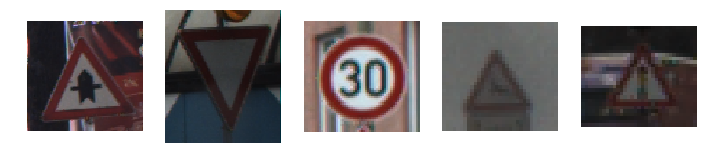

In [32]:
gs = gridspec.GridSpec(1, 5)
gs.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12, 4))

for i, image in enumerate(images):
    ax = plt.subplot(gs[i])
    ax.set_aspect('equal')    
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')    

plt.show()

In [14]:
sign_names_path = base_path + 'signnames.csv'
sign_names = pd.read_csv(sign_names_path, header=0)
sign_names.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [15]:
def get_top_n(prediction, sign_names, n=5):
    pred = list(prediction)
    classes, probs = [], []
    for i in range(n):
        index = np.argmax(pred)
        sign_name = sign_names[sign_names['ClassId'] == index]['SignName'].values[0]
        classes.append(sign_name)
        
        probs.append(max(pred))
        pred[index] = 0
    
    return classes, probs

In [33]:
processed_images = np.zeros((len(images), 32, 32, 3))
for i, path in enumerate(test_paths):
    processed_images[i] = get_image(path)
predictions = model.predict_on_batch(processed_images)

In [17]:
# IN PROGRESS

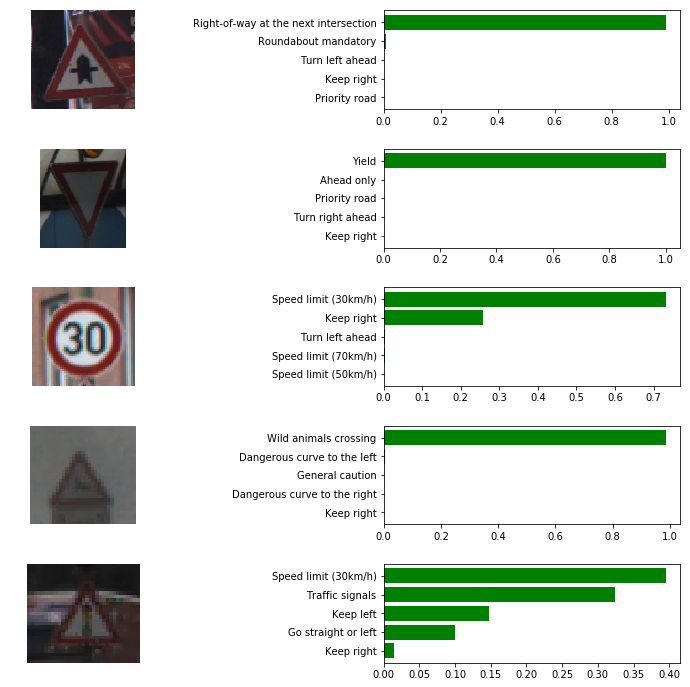

In [34]:
gs = gridspec.GridSpec(n_test, 2, width_ratios=[4, 2])
gs.update(wspace=0.01, hspace=0.4)
plt.figure(figsize=(16, 12))

for i in range(n_test):
    ax = plt.subplot(gs[i, 0])
    ax.set_aspect('equal')    
    plt.imshow(images[i])
    plt.axis('off')
    
    signs, probs = get_top_n(predictions[i], sign_names)
    
    ax = plt.subplot(gs[i, 1])
    y_pos = np.arange(len(signs))    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signs)
    ax.barh(y_pos, probs, align='center', color='green')
    ax.invert_yaxis()